In [1]:
import pandas as pd
from datetime import datetime
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np

In [2]:
target = "TSDip-1.txt"

In [3]:
df = pd.read_csv(f"/home/rod/Documents/DataScience/my_projects/tsdip/data/{target}",sep="\t")

## Data preparation

### Cleaning up and refactoring column names

In [4]:
# droping unused columns
df.drop(['SS','FileName','Ser','Meas ','Sal. ','Cond. ','Temp ',' %O2 ','mg/l'],axis=1,inplace=True) 
# renaming columns
df.columns=['SoS','Depth','year','month','day','hour','minute','second']                             
# keep only  depths above 2.0 meters
df = df[df['Depth']>2.0]            
# parsing datetime columnes to single 'date' columns
df['date']=pd.to_datetime(df[['year', 'month', 'day', 'hour','minute','second']])     

# dealing with time to calculate deployment and recovery speed
df['time_shift'] = df['date'].shift()
df['time_diff']=(df['date']-df['time_shift'])/ pd.Timedelta(seconds=1)
df['depth_shifted']=df['Depth'].shift()
df['depth_step(m)']=abs(df['Depth']-df['depth_shifted'])
df['dip_speed(m/s)'] = abs(df['depth_step(m)']/df['time_diff'])
# cleaning up temp columns
df.drop(['time_shift','time_diff','depth_shifted','depth_step(m)','year', 'month', 'day', 'hour','minute','second'],axis=1,inplace=True)

# finalizing the dataframe
# spliting date and time in sperate columns
df["Date"] = df["date"].dt.date                                                                      
df["Time"] = df["date"].dt.time                                                                      
# droping unused columns and reseting indexes
df.drop("date",axis=1,inplace=True)                                                                  
df.reset_index(inplace=True)                                                                         
df.reset_index(inplace=True)                                                                         

### defining dip direction (up or down)

In [5]:
# find index of the max depth value
tmax=df['Time'][df['Depth']==df['Depth'].max()].index        
# create 'direction' columns based on index level
df['direction'] = np.where(df['level_0']<=tmax[0], 'down', 'up')                                    
# remove unused column
df.drop(['level_0','index'],axis=1,inplace=True)                                                    

### spliting dataframe by direction and depth

In [6]:
# full column dataframe for each direction
df_up=df[df['direction']=='up']
df_down=df[df['direction']=='down']

# top 50m dataframe in each direction
top = df[df['Depth']<=50] 
top_up=top[top['direction']=='up']
top_down=top[top['direction']=='down']

In [48]:
pwd

'/home/rod/Documents/DataScience/my_projects/tsdip'

In [67]:
df_down[['SoS','Depth']].to_csv(f"home_files/{target[0:7]}.csv")

## Creating graphs

### Speed of sound profiles

#### Full column

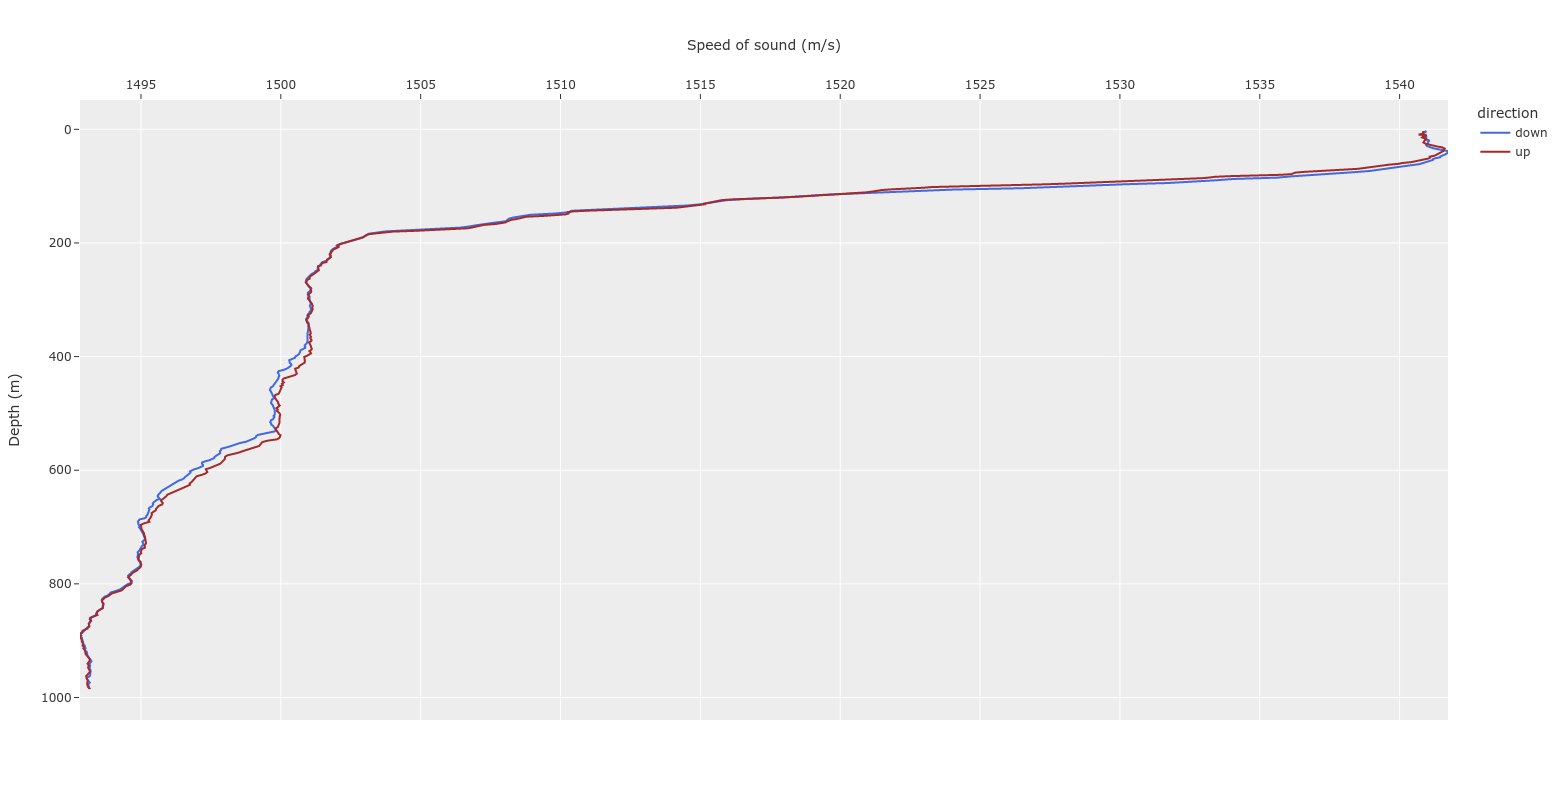

In [33]:
fig = make_subplots(
    rows=1,cols=1)

fig.add_trace(
    go.Scatter(x=df_down['SoS'],y=df_down['Depth'],line=dict(color='royalblue'),name="down"),
    row=1,col=1
)

fig.add_trace(
    go.Scatter(x=df_up['SoS'],y=df_up['Depth'],line=dict(color='brown'),name="up",),
    row=1,col=1
)

fig.update_yaxes(autorange="reversed", row=1, col=1)

fig.update_layout(
    xaxis={'side':'top'},
    xaxis_title="Speed of sound (m/s)",
    yaxis_title="Depth (m)",
    legend_title="direction",
    template='ggplot2',
    height=800,
    width=600,
    
    
)


#### Top 50m

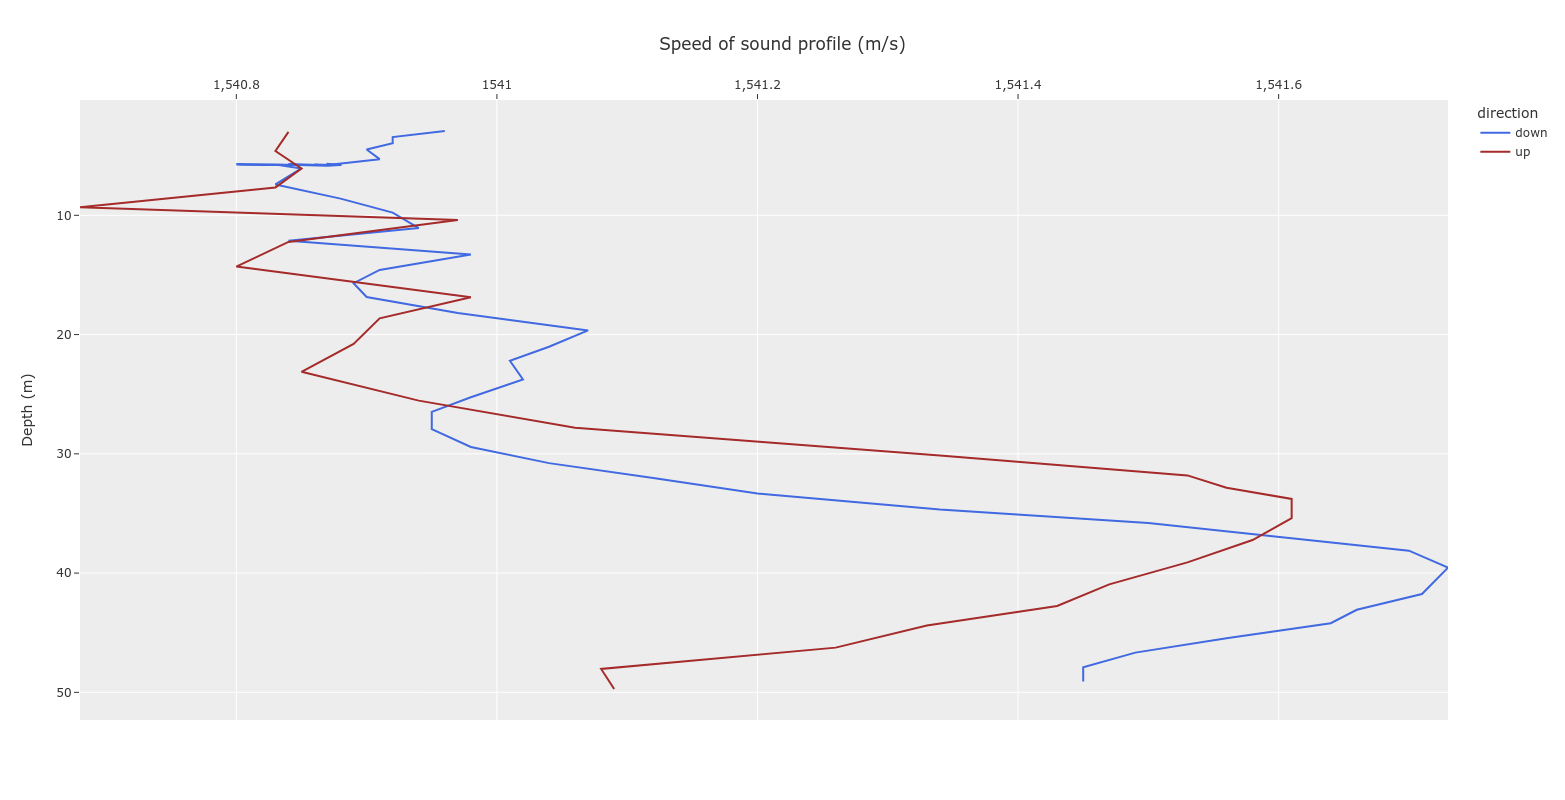

In [34]:
fig2 = make_subplots(
    rows=1,cols=1)

fig2.add_trace(
    go.Scatter(x=top_down["SoS"],y=top_down["Depth"],line=dict(color='royalblue'),name='down'),
    row=1,col=1
)

fig2.add_trace(
    go.Scatter(x=top_up["SoS"],y=top_up["Depth"],line=dict(color='brown'),name='up'),
    row=1,col=1
)


fig2.update_yaxes(autorange="reversed", row=1, col=1)

fig2.update_layout(
    xaxis={'side':'top'},
    xaxis_title="Speed of sound (m/s)",
    yaxis_title="Depth (m)",
    legend_title="direction",
    template='ggplot2',
    height=800,
    width=600,
)


### Deployment and recovery speed

In [8]:
df_up.head()

,SoS,Depth,dip_speed(m/s),Date,Time,direction
532,1493.15,984.53,0.275,2022-11-07,04:52:00,up
533,1493.16,984.17,0.180,2022-11-07,04:52:02,up
534,1493.15,983.65,0.260,2022-11-07,04:52:04,up
535,1493.11,981.77,0.940,2022-11-07,04:52:06,up
536,1493.09,979.49,1.140,2022-11-07,04:52:08,up


#### Deployment speed (m/s)

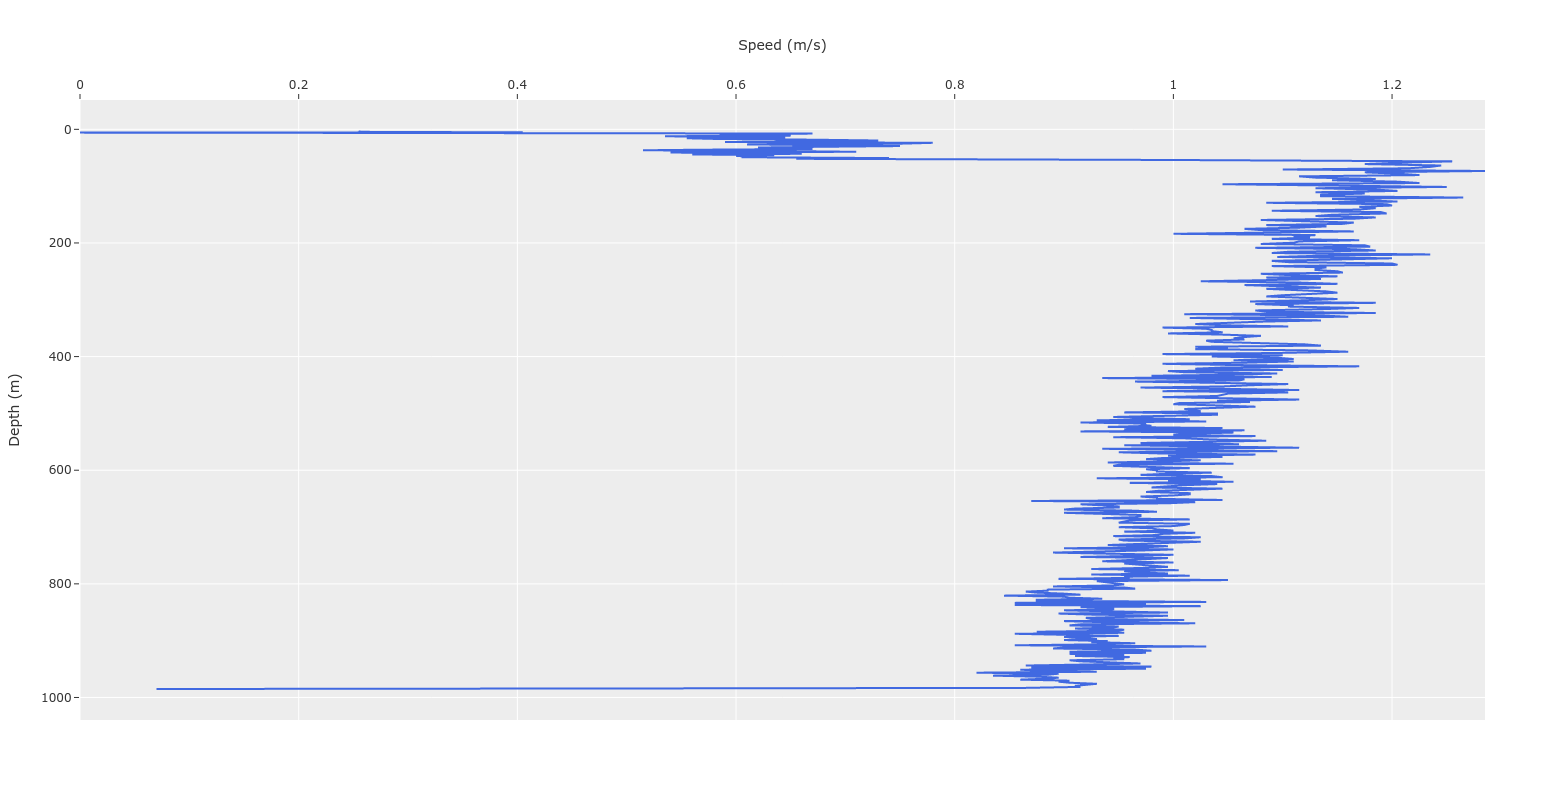

In [44]:
fig3 = make_subplots(
    rows=1,cols=1)

fig3.add_trace(
    go.Scatter(x=df_down['dip_speed(m/s)'],y=df_down['Depth'],line=dict(color='royalblue'),showlegend=False),
    row=1,col=1
)

fig3.update_yaxes(autorange="reversed", row=1, col=1)

fig3.update_layout(
    xaxis={'side':'top'},
    xaxis_title="Speed (m/s)",
    yaxis_title="Depth (m)",
    template='ggplot2',
    height=800,
    width=600,
    
    
)

#### Recovery speed (m/s)

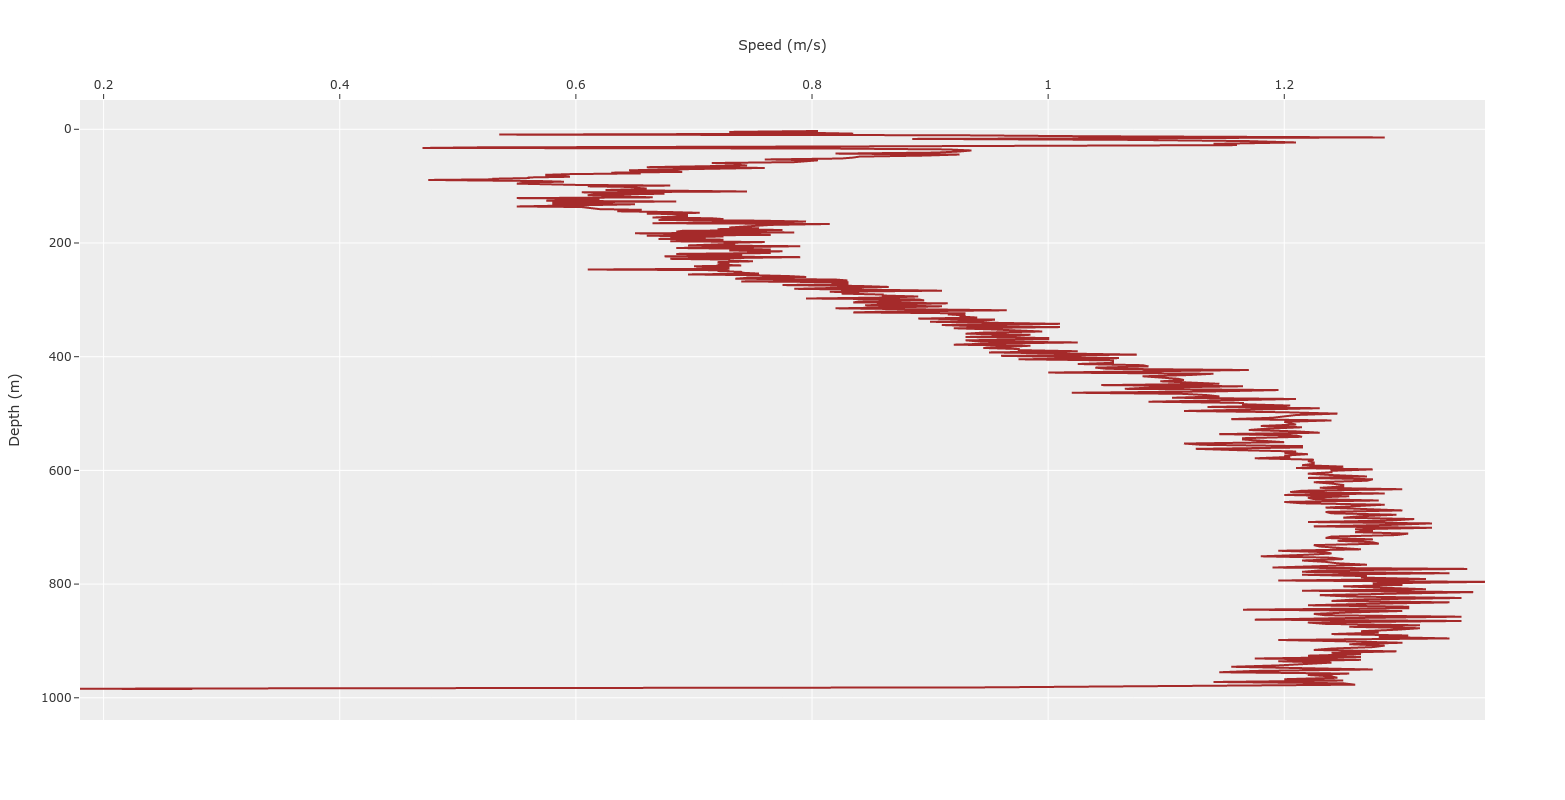

In [45]:
fig4 = make_subplots(
    rows=1,cols=1)

fig4.add_trace(
    go.Scatter(x=df_up['dip_speed(m/s)'],y=df_up['Depth'],line=dict(color='brown'),showlegend=False),
    row=1,col=1
)

fig4.update_yaxes(autorange="reversed", row=1, col=1)

fig4.update_layout( 
    xaxis={'side':'top'},
    xaxis_title="Speed (m/s)",
    yaxis_title="Depth (m)",
    template='ggplot2',
    height=800,
    width=600,
    
    
)

In [67]:
df_down['dip_speed(m/s)'].describe()

count    531.000000
mean       0.926149
std        0.276808
min        0.000000
25%        0.915000
50%        0.990000
75%        1.080000
max        1.285000
Name: dip_speed(m/s), dtype: float64

In [68]:
df_up['dip_speed(m/s)'].describe()

count    501.000000
mean       0.980120
std        0.256319
min        0.180000
25%        0.740000
50%        1.000000
75%        1.225000
max        1.370000
Name: dip_speed(m/s), dtype: float64